# US Video Game Sales in Relation to ESRB Rating and Genre

By Riley Stange
<br>For Thinkful Capstone 1: Business Research

## 1. Introduction

Having been an avid video gamer for most of my life, I found this to be an interesting subject matter, in which I have relevant experience.

I found a dataset on Kaggle, Video Game Sales with Ratings, and after looking through it, I realized it would be interesting to see what insights can be gathered from how an ESRB maturity rating correlates with sales figures. 

Starting with a more broad comparison between different ratings, and then breaking down the differences between various genres, the goal is to see the degree of impact a maturity rating has on the sale of video games, in general, and in more specific cases tied to the different genres.

### ESRB Ratings

**E**: "Everyone": Content is generally suitable for all ages. May contain minimal cartoon, fantasy or mild violence and/or infrequent use of mild language.

**E10+**: "Everyone 10+": Content is generally suitable for ages 10 and up. May contain more cartoon, fantasy or mild violence, mild language and/or minimal suggestive themes.

**T**: "Teen": Content is generally suitable for ages 13 and up. May contain violence, suggestive themes, crude humor, minimal blood, simulated gambling and/or infrequent use of strong language.

**M**: "Mature 17+": Content is generally suitable for ages 17 and up. May contain intense violence, blood and gore, sexual content and/or strong language.

**AO**: "Adults Only 18+": Content suitable for adults ages 18 and up. May include prolonged scenes of intense violence, graphic sexual content and/or gambling with real currency.

### Relevance

From investors, publishing companies, all the way down to individual game studios; the insights gained from this experiment will help them to understand the profitability of content in video games, in general, and most importantly, in the context of different genres. This helps to maximize the use of investment capital and labor towards designing video games in such a way that they are most relevant to their target audience, and most profitable.

## 2. Hypothesis

$H_0$: There is no significant difference in sales based on maturity rating.

$H_A$: There is a significant difference in sales based on maturity rating.

## 3. Data

In [1]:
# Initialize the environment
import math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline
sns.set(style="darkgrid")

In [2]:
sales = pd.read_csv(
    "~/projects/video-game-sales-by-maturity-rating/Video_Games_Sales_as_at_22_Dec_2016.csv"
)

In [3]:
# Only pull from entries where there are US sales
# and where there is a rating
na_sales = sales[
    (sales["NA_Sales"] > 0) & sales.Rating.notnull()
]
na_sales["NA_Sales"].count()

9174

**Source**
<br>The data is sourced from [Kaggle](https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings) and contains 9,174 observations, after filtering for our criteria of video games that have sold > 0 copies in the US, and have a rating. Changed any observation with the obsolete (as of 1998) rating of 'K-A' to 'E', since they are considered equivalent.

In [4]:
na_sales["Rating"].value_counts()

E       3764
T       2650
M       1423
E10+    1328
EC         8
AO         1
Name: Rating, dtype: int64

It appears that additional filtering of the dataset is in order, as we only have one observation in the 'AO' category, and only 8 in the now (as of 2018) retired 'EC' category.

In [5]:
# Eliminating the sparse/irrelevant Adults Only/Early Childhood rated observations.
na_sales_e_to_m = sales[
    (sales["NA_Sales"] > 0)
    & sales.Rating.notnull()
    & (sales["Rating"] != "AO")
    & (sales["Rating"] != "EC")
]

## 4. Methods

### 1. Does Maturity Rating Effect Sales in General?

First, I will graph the data in general to get an idea of it's distribution.

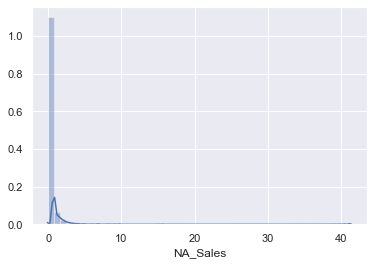

In [30]:
sns.distplot(na_sales_e_to_m["NA_Sales"], norm_hist=True)
plt.show()

Definitely not normal, so I do not need to do any statistical tests to confirm for normality. I will now use the Kruskal-Wallace test to see if I can refuse the null. Also I can just barely see that there is one extreme outlier that had sales of more than 40 million USD. I will look more into this later.

#### Kruskal-Wallis

In [7]:
stats.kruskal(
    na_sales_e_to_m["NA_Sales"][
        na_sales_e_to_m["Rating"] == "E"
    ],
    na_sales_e_to_m["NA_Sales"][
        na_sales_e_to_m["Rating"] == "E10+"
    ],
    na_sales_e_to_m["NA_Sales"][
        na_sales_e_to_m["Rating"] == "T"
    ],
    na_sales_e_to_m["NA_Sales"][
        na_sales_e_to_m["Rating"] == "M"
    ],
)

KruskalResult(statistic=63.500405432609654, pvalue=1.0497237548692599e-13)

**Results**

From this, we can tell that at least one group is significantly different from the other three, and so for this broader null, we can reject it and move onto a more focused hypothesis and get more details on how significant those differences are, and based on what Ratings and Genres. 

### 2. Revealing Where The Differences Are, and Which Are Most Significant

#### Boxen Plot by Rating

To start, I will utilize a categorical boxen plot to give a clearer view of distribution's shape within each rating, and any outliers.

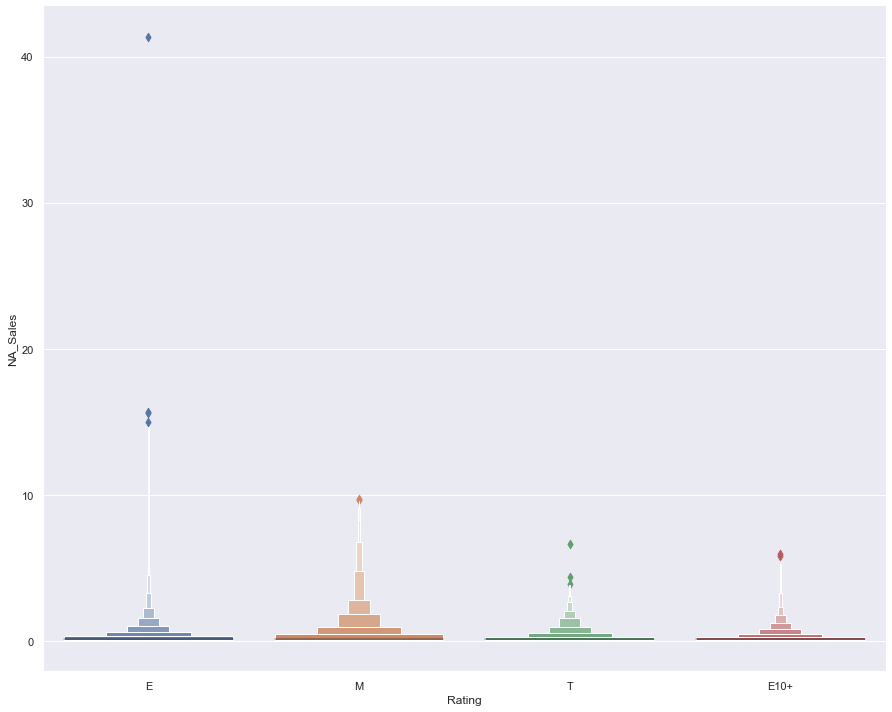

In [28]:
sns.catplot(
    x="Rating",
    y="NA_Sales",
    kind="boxen",
    height=10,
    aspect=1.25,
    data=na_sales_e_to_m,
)
plt.show()

From a quick glance, I first notice that the 40 million+ outlier is within the E rating. However, it appears there is a lot of activity going on in the Mature rated category. It may be useful to see the total sales per category at a later point to see the size of the total market in each maturity category, to determine the most profitable demographics. Now, to satisfy my own (and possibly anyone else's) curiousity, I will see what that outlier is. 

In [9]:
na_sales_e_to_m[na_sales_e_to_m["NA_Sales"] > 40]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E


#### Tukey HSD Test

Now I will perform the Tukey HSD test to compare the differences between the different ratings.

In [10]:
tukey = pairwise_tukeyhsd(
    endog=na_sales_e_to_m["NA_Sales"],  # Data
    groups=na_sales_e_to_m["Rating"],  # Groups
    alpha=0.05, # Significance level
)  

In [11]:
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
E,E10+,-0.0782,0.0197,-0.1476,-0.0089,True
E,M,0.1817,0.001,0.1141,0.2493,True
E,T,-0.0576,0.0366,-0.1127,-0.0025,True
E10+,M,0.2599,0.001,0.177,0.3428,True
E10+,T,0.0206,0.8777,-0.0524,0.0937,False
M,T,-0.2393,0.001,-0.3107,-0.1679,True


**Results**

Based on these results, we can reject the null in every case, except for comparing the differences of the means of E10+ and T ratings sales.
<br>The most significant differences in means are seen between: E10+-M, M-T, and E-M.
<br>

### 3. Best Performing Genres for Mature Rated Games

#### Hypothesis

After getting an idea of the big picture of where the greatest differences are in means sales between genres, I notice that the greatest differences in means are when comparing any group to the M rated group. This will lead into the next hypothesis I will test for: 

$H_0$: Mature rated games **do not** sell better than games with other ratings

$H_A$: Mature rated games **do** sell better than games with other ratings.

#### Boxen Plotting The Genres

I will utilize another boxen plot. 
<br>But first, for this plot, due to the "Wii Sports" outlier, we will make a copy of our dataset, and then clip it's sale values to 16 million, more in line with the others, to get a clearer picture of what is happening at the lower end of the plot.

In [12]:
clipped_sales = na_sales_e_to_m.copy()
clipped_sales["NA_Sales"] = na_sales_e_to_m[
    "NA_Sales"
].clip(upper=16)

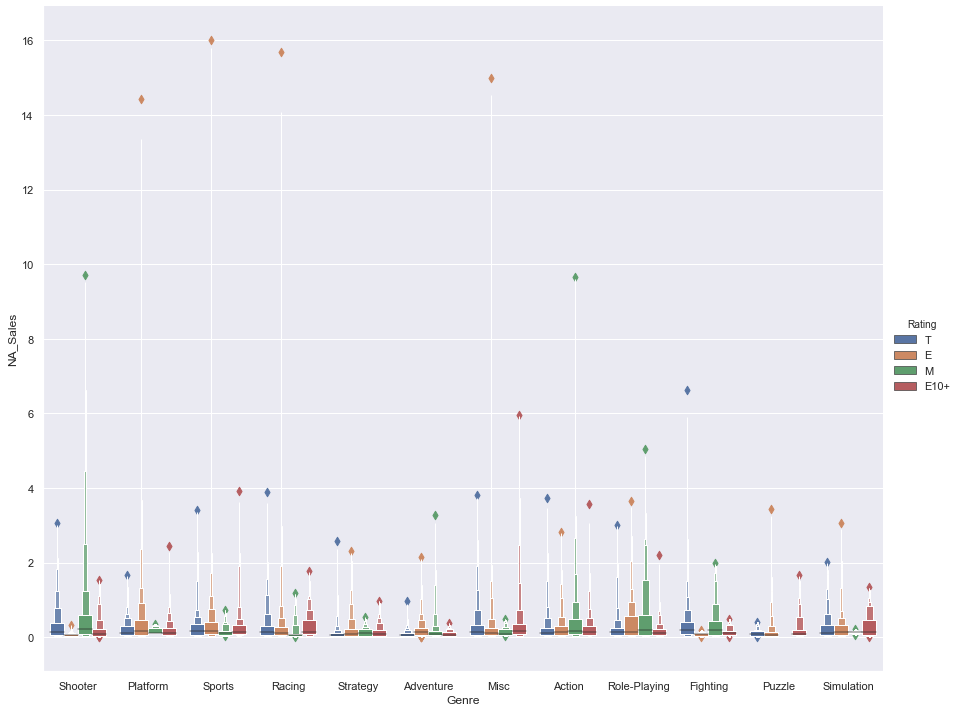

In [37]:
sns.catplot(
    x="Genre",
    y="NA_Sales",
    kind="boxen",
    hue="Rating",
    height=10,
    aspect=1.25,
    data=clipped_sales.sort_values("NA_Sales")
)
plt.show()

Starting from the top of the chart: we have four titles that sold for over 14 million USD, one from Sports, one from Racing, one from Misc, and one from Platform. All of which are rated E.<br>
This aligns with intuition, to see that the best sellers (including the one outlier that sold for 41 million USD) are all rated E, where their content is not offensive to anyone in particular, allowing for the largest potential audience.<br>
This however, does not mean that games of other ratings do not have a valid audience, and as we see, there are only four games that sold for more than 14 million USD, but if you look at where the bulk of the action is happening, below the 5 million, and mostly below the 2.5 million mark, it seems that there is a potentially much larger market for M rated games, especially within the Shooter, Role-Playing, and to a lesser extent, Action genres.<br>
A next step is to take a closer look at each genre and compare the sales statistics based on genre.

#### 1. Shooter Sales by Genre

First I will start with the Shooter genre, where it appears that Mature rated games do well. Since we are now working with a smaller set of data, we can utilize a categorical swarm plot to see each individual data point, which makes it clearer where the density lies in each rating within this genre. 

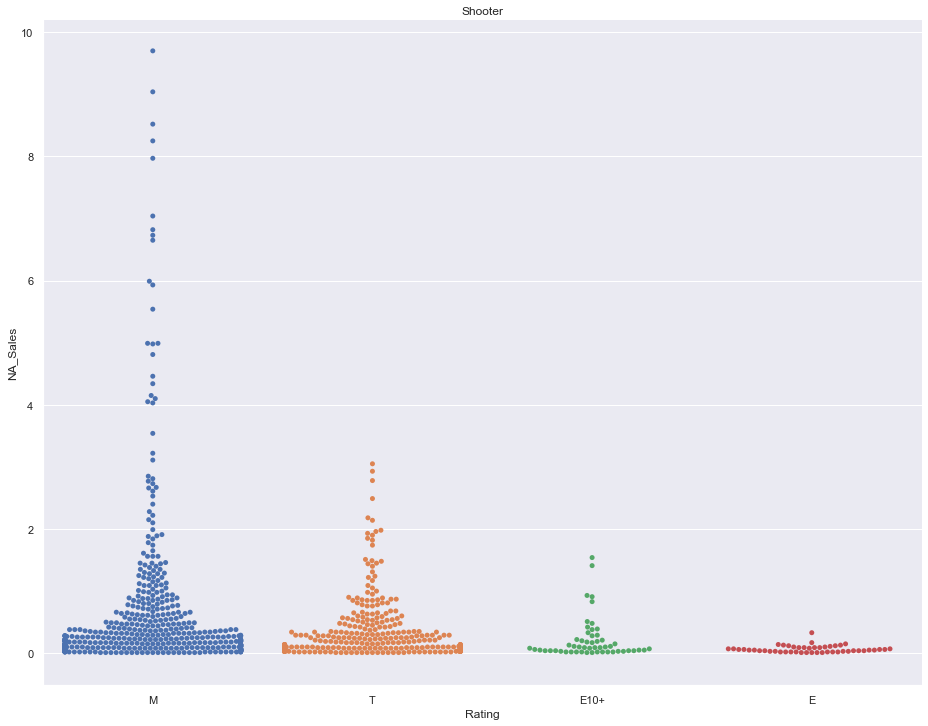

In [39]:
sns.catplot(
    x="Rating",
    y="NA_Sales",
    kind="swarm",
    height=10,
    aspect=1.3,
    data=na_sales_e_to_m[
        na_sales_e_to_m["Genre"] == "Shooter"
    ],
)
plt.title("Shooter")
plt.show()


Lets check the two-tail confidence interval between Mature and Teen rated shooters first

In [15]:
def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt(
        (sample_1_var / sample_1_n)
        + (sample_2_var / sample_2_n)
    )
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return (
        "The difference in means at the 95% confidence interval (two-tail) is between "
        + str(ci_lower)
        + " and "
        + str(ci_upper)
        + "."
    )

In [16]:
m_shooters = na_sales_e_to_m[
    (na_sales_e_to_m["Rating"] == "M")
    & (na_sales_e_to_m["Genre"] == "Shooter")
]
t_shooters = na_sales_e_to_m[
    (na_sales_e_to_m["Rating"] == "T")
    & (na_sales_e_to_m["Genre"] == "Shooter")
]
print(
    get_95_ci(
        t_shooters["NA_Sales"], m_shooters["NA_Sales"]
    )
)
print(
    "The average sale for a Teen rated shooter is {}".format(
        t_shooters["NA_Sales"].mean()
    )
)
print(
    "The average sale for a Mature rated shooter is {}".format(
        m_shooters["NA_Sales"].mean()
    )
)

The difference in means at the 95% confidence interval (two-tail) is between 0.19712538915966707 and 0.4484317230099417.
The average sale for a Teen rated shooter is 0.33840361445783135
The average sale for a Mature rated shooter is 0.6611821705426357


We can see that, with a 95% confidence interval (two-tail), that Mature shooters sell between ~197K and ~448K USD more than Teen rated shooters, with the mean M-Rated shooter total sales coming in at ~661K USD, almost double the mean sales of a Teen rated shooter at ~338K USD. Now it is up to further research to see what makes Mature Rated shooters sell more than Teen rated shooters. Perhaps the target audience of shooters prefer greater degrees of realism in violence that cannot be found in a rating lower than Mature? One of the defining aspects of the Shooter genre is that you are immersed in the first person, and perhaps unrealistic violence would be detrimental to that immersive experience that most buyers in that market are looking for.